In [ ]:
import sys
import os

import h5py

import numpy as np

from astropy.io import fits

import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from mrileyowens.stats import weighted_quantile

In [ ]:
def compare():

    '''
    Compare absolute UV magnitude measurements of the photometric catalog of F775W dropouts from Endsley et al. (2024) by Endsley et al. (2024) and my own
    measurements based on my BEAGLE fits to the catalog
    '''

    # Set common directories
    home = os.getcwd()
    data = f'{home}/data'
    figs = f'{home}/figs'
    results = f'{home}/results'

    # Get the photometric catalog of F775W dropouts from Endsley et al. (2024)
    catalog = fits.open(f'{data}/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts.fits')

    # Open my own measurements of the absolute UV magnitude from the BEAGLE fits I made to the Endsley et al. (2024) photometric catalog of F775W dropouts
    with h5py.File(f'{results}/m_uv/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts_beagle_csfh_fits_m_uv.h5', 'r') as f:

        # Get the IDs of the objects
        ids = f.keys()

        # Make a figure to plot the two sets of measurements against each other
        fig, ax = plt.subplots()

        # For each object ID
        for i, id in enumerate(ids):

            # Calculate the object ID's matching index in the Endsley et al. (2024) catalog
            idx_endsley2024 = np.where(catalog[1].data['ID'] == id)

            # Get the median, 16th, and 84th percentiles of the absolute UV magnitudes of Endsley et al. (2024)
            m_uv_endsley2024, m_uv_endsley2024_lower, m_uv_endsley2024_upper = catalog[1].data['Muv'][idx_endsley2024][0], catalog[1].data['Muv_l16'][idx_endsley2024][0], catalog[1].data['Muv_u84'][idx_endsley2024][0]

            # Get the posteriors and corresponding probabilities of my own absolute UV magnitude measurements of the Endsley et al. (2024) F775W dropout catalog
            m_uv_me_posterior, probabilities = f[id]['m_uv'][:], f[id]['probabilities'][:]

            # Calculate the median, 16th, and 84th percentiles of the posteriors of my own absolute UV magnitude measurements
            m_uv_me, m_uv_me_lower, m_uv_me_upper = weighted_quantile(m_uv_me_posterior, probabilities, 0.5), weighted_quantile(m_uv_me_posterior, probabilities, 0.16), weighted_quantile(m_uv_me_posterior, probabilities, 0.84)

            # Plot the two sets of measurements against each other
            ax.errorbar(m_uv_me, m_uv_endsley2024, xerr=[[abs(m_uv_me_lower - m_uv_me)],[abs(m_uv_me_upper - m_uv_me)]], yerr=[[abs(m_uv_endsley2024_lower - m_uv_endsley2024)], [abs(m_uv_endsley2024_upper - m_uv_endsley2024)]], 
                color='black')
            
        # Create a one-to-one line on the figure
        ax.axline((-20,-20), slope=1, color='red', linestyle='dashed')

        # Label the axes
        ax.set_xlabel(r'$M_\text{UV}$ (me)')
        ax.set_ylabel(r'$M_\text{UV}$ (Endsley et al. (2024))')

        # Set the title of the figure
        ax.set_title(r'Comparing $M_\text{UV}$ measurements of the F775W dropouts from Endsley et al. (2024)')

        # Save the figure
        fig.savefig(f'{figs}/m_uv_measurements_comparison.png', dpi=200, bbox_inches='tight')

def compare_diff():

    '''
    '''

    # Set common directories
    home = os.getcwd()
    data = f'{home}/data'
    figs = f'{home}/figs'
    results = f'{home}/results'

    # Get the photometric catalog of F775W dropouts from Endsley et al. (2024)
    catalog = fits.open(f'{data}/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts.fits')

    # Open my own measurements of the absolute UV magnitude from the BEAGLE fits I made to the Endsley et al. (2024) photometric catalog of F775W dropouts
    with h5py.File(f'{results}/m_uv/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts_beagle_csfh_fits_m_uv.h5', 'r') as f:

        # Get the IDs of the objects
        ids = np.array([key for key in f.keys()], dtype=str)

        # Make a figure to plot the two sets of measurements against each other
        #fig, ax = plt.subplots()

        diffs_m_uv = []
        diffs_z = []

        # For each object ID
        for i, id in enumerate(ids):

            # Calculate the object ID's matching index in the Endsley et al. (2024) catalog
            idx_endsley2024 = np.where(catalog[1].data['ID'] == id)

            # Get the median, 16th, and 84th percentiles of the absolute UV magnitudes of Endsley et al. (2024)
            m_uv_endsley2024 = catalog[1].data['Muv'][idx_endsley2024][0]

            # Get the posteriors and corresponding probabilities of my own absolute UV magnitude measurements of the Endsley et al. (2024) F775W dropout catalog
            m_uv_me_posterior, probabilities = f[id]['m_uv'][:], f[id]['probabilities'][:]

            # Calculate the median, 16th, and 84th percentiles of the posteriors of my own absolute UV magnitude measurements
            m_uv_me = weighted_quantile(m_uv_me_posterior, probabilities, 0.5)

            diffs_m_uv.append(m_uv_endsley2024 - m_uv_me)

            # Get the median, 16th, and 84th percentiles of the absolute UV magnitudes of Endsley et al. (2024)
            #print(catalog[1].data.columns.names)
            z_endsley2024 = catalog[1].data['zphot'][idx_endsley2024][0]

            # Get the posteriors and corresponding probabilities of my own absolute UV magnitude measurements of the Endsley et al. (2024) F775W dropout catalog
            #print(fits.open(f'full_w335m_mup300/{id}_BEAGLE.fits.gz').info())
            z_me_posterior = fits.open(f'{results}/beagle_fits/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts_beagle_csfh_fits/{id}_BEAGLE.fits.gz')['GALAXY PROPERTIES'].data['redshift']
            probabilities = fits.open(f'{results}/beagle_fits/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts_beagle_csfh_fits/{id}_BEAGLE.fits.gz')['POSTERIOR PDF'].data['probability']

            # Calculate the median, 16th, and 84th percentiles of the posteriors of my own absolute UV magnitude measurements
            z_me = weighted_quantile(z_me_posterior, probabilities, 0.5)

            diffs_z.append(z_endsley2024 - z_me)

            # Plot the two sets of measurements against each other
            #ax.errorbar(m_uv_me, m_uv_endsley2024, xerr=[[abs(m_uv_me_lower - m_uv_me)],[abs(m_uv_me_upper - m_uv_me)]], yerr=[[abs(m_uv_endsley2024_lower - m_uv_endsley2024)], [abs(m_uv_endsley2024_upper - m_uv_endsley2024)]], 
            #    color='black')
            
        diffs_m_uv = np.array(diffs_m_uv, dtype=np.float64)
        diffs_z = np.array(diffs_z, dtype=np.float64)
            
        fig, ax = plt.subplots()

        ax.scatter(diffs_z, diffs_m_uv, facecolors='none', edgecolors='black')

        ax.set_xlabel('$\Delta z$ (Endsley et al. (2024) $-$ this work)')
        ax.set_ylabel(r'$\Delta M_\text{UV}$ (Endsley et al. (2024) $-$ this work)')

        ax.set_title('Differences between the two sets of measurements of F775W dropouts from Endsley et al. (2024)')

        # Create a one-to-one line on the figure
        ax.axline((0,0), slope=-1, color='red', linestyle='dashed')

        #ax.loglog()

        fig.savefig(f'{figs}/delta_m_uv_z.png', dpi=200, bbox_inches='tight')

        #diffs_m_uv = np.array(diffs_m_uv, dtype=np.float64)
            
        ids_diffs = ids[abs(diffs_m_uv) >= 0.2]

        print('Number of objects with a >= 0.2 mag difference between the two sets of M_UV measurements:', len(ids_diffs), '\n')
        print('Object IDs with a >= 0.2 mag difference between the two sets of M_UV measurements:', ids_diffs)
            
        # Create a one-to-one line on the figure
        #ax.axline((-20,-20), slope=1, color='red', linestyle='dashed')

        ## Label the axes
        #ax.set_xlabel(r'$M_\text{UV}$ (me)')
        #ax.set_ylabel(r'$M_\text{UV}$ (Endsley et al. (2024))')

        ## Set the title of the figure
        #ax.set_title(r'Comparing $M_\text{UV}$ measurements of the F775W dropouts from Endsley et al. (2024)')

        ## Save the figure
        #fig.savefig(f'{figs}/m_uv_measurements_comparison.png', dpi=200, bbox_inches='tight')

def bins():

    '''
    Compare the galaxies in different absolute UV magnitude bins under my own measurements and that of Endsley et al. (2024)
    '''

    # Set common directories
    home = os.getcwd()
    data = f'{home}/data'
    results = f'{home}/results'

    # ------------------------------------------------------------------------------------------------------------
    # Determine the object IDs in each absolute UV magnitude bin according to Endsley et al. (2024)'s measurements
    # ------------------------------------------------------------------------------------------------------------

    # Get the photometric catalog of F775W dropouts from Endsley et al. (2024)
    catalog = fits.open(f'{data}/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts.fits')

    # Get the object IDs from the photometric catalog of F775W dropouts from Endsley et al. (2024)
    ids_endsley2024 = catalog[1].data['ID']

    # Get the median of the absolute UV magnitudes of Endsley et al. (2024)
    m_uv_endsley2024 = catalog[1].data['Muv']

    # Get the groups of IDs in each absolute UV magnitude bin
    ids_endsley2024_bright = ids_endsley2024[m_uv_endsley2024 <= -19.5]
    ids_endsley2024_faint = ids_endsley2024[(m_uv_endsley2024 > -19.5) & (m_uv_endsley2024 <= -18)]
    ids_endsley2024_vfaint = ids_endsley2024[m_uv_endsley2024 > -18]

    # ------------------------------------------------------------------------------------------------------------
    # Determine the object IDs in each absolute UV magnitude bin according to my measurements
    # ------------------------------------------------------------------------------------------------------------

    # Open my own measurements of the absolute UV magnitude from the BEAGLE fits I made to the Endsley et al. (2024) photometric catalog of F775W dropouts
    with h5py.File(f'{results}/m_uv/JADES_z6to9LBGcatalog_Endsley2024_f775w_dropouts_beagle_csfh_fits_m_uv.h5', 'r') as f:

        # Get the IDs of the objects
        ids = np.array([key for key in f.keys()], dtype=str)

        m_uvs_me = []

        # For each object ID
        for i, id in enumerate(ids):

            # Get the posteriors and corresponding probabilities of my own absolute UV magnitude measurements of the Endsley et al. (2024) F775W dropout catalog
            m_uv_me_posterior, probabilities = f[id]['m_uv'][:], f[id]['probabilities'][:]

            # Calculate the median, 16th, and 84th percentiles of the posteriors of my own absolute UV magnitude measurements
            m_uv_me = weighted_quantile(m_uv_me_posterior, probabilities, 0.5)

            m_uvs_me.append(m_uv_me)

        m_uvs_me = np.array(m_uvs_me, dtype=np.float64)

        ids_me_bright = ids[m_uvs_me <= -19.5]
        ids_me_faint = ids[(m_uvs_me > -19.5) & (m_uvs_me <= -18)]
        ids_me_vfaint = ids[m_uvs_me > -18]

        print('The number of objects in Endsley et al. (2024)\'s bright (M_UV <= -19.5) selection: ', len(ids_endsley2024_bright))
        print('The number of objects in Endsley et al. (2024)\'s faint (-19.5 < M_UV <= -18) selection: ', len(ids_endsley2024_faint))
        print('The number of objects in Endsley et al. (2024)\'s very faint (M_UV > -18) selection: ', len(ids_endsley2024_vfaint), '\n')

        print('The number of objects in my bright (M_UV <= -19.5) selection: ', len(ids_me_bright))
        print('The number of objects in my faint (-19.5 < M_UV <= -18) selection: ', len(ids_me_faint))
        print('The number of objects in my very faint (M_UV > -18) selection: ', len(ids_me_vfaint), '\n')

        print('The number of objects in both bright (M_UV <= -19.5) selections: ', len(np.intersect1d(ids_endsley2024_bright, ids_me_bright)))
        print('The number of objects in both faint (-19.5 < M_UV <= -18) selections: ', len(np.intersect1d(ids_endsley2024_faint, ids_me_faint)))
        print('The number of objects in both very faint (M_UV > -18) selections: ', len(np.intersect1d(ids_endsley2024_vfaint, ids_me_vfaint)), '\n')

        mask_bright_to_faint = []
        mask_bright_to_vfaint = []
        mask_faint_to_bright = []
        mask_faint_to_vfaint = []
        mask_vfaint_to_bright = []
        mask_vfaint_to_faint = []

        delta_m_uvs = []

        for i, id in enumerate(ids):

            idx = np.where(ids_endsley2024 == id)            

            bool_bright_to_faint = (m_uv_endsley2024[idx] <= -19.5) & ((-19.5 < m_uvs_me[i]) & (m_uvs_me[i] <= -18))
            bool_bright_to_vfaint = (m_uv_endsley2024[idx] <= -19.5) & (m_uvs_me[i] > -18)

            bool_faint_to_bright = ((-19.5 < m_uv_endsley2024[idx]) & (m_uv_endsley2024[idx] <= -18)) & (m_uvs_me[i] <= -19.5)
            bool_faint_to_vfaint = ((-19.5 < m_uv_endsley2024[idx]) & (m_uv_endsley2024[idx] <= -18)) & (m_uvs_me[i] > -18)

            bool_vfaint_to_bright = (m_uv_endsley2024[idx] > -18) & (m_uvs_me[i] <= -19.5)
            bool_vfaint_to_faint = (m_uv_endsley2024[idx] > -18) & ((-19.5 < m_uvs_me[i]) & (m_uvs_me[i] <= -18))

            mask_bright_to_faint.append(bool_bright_to_faint[0])
            mask_bright_to_vfaint.append(bool_bright_to_vfaint[0])
            mask_faint_to_bright.append(bool_faint_to_bright[0])
            mask_faint_to_vfaint.append(bool_faint_to_vfaint[0])
            mask_vfaint_to_bright.append(bool_vfaint_to_bright[0])
            mask_vfaint_to_faint.append(bool_vfaint_to_faint[0])

            delta_m_uvs.append((m_uv_endsley2024[idx] - m_uvs_me[i])[0])

        mask_bright_to_faint = np.array(mask_bright_to_faint, dtype=bool)
        mask_bright_to_vfaint = np.array(mask_bright_to_vfaint, dtype=bool)
        mask_faint_to_bright = np.array(mask_faint_to_bright, dtype=bool)
        mask_faint_to_vfaint = np.array(mask_faint_to_vfaint, dtype=bool)
        mask_vfaint_to_bright = np.array(mask_vfaint_to_bright, dtype=bool)
        mask_vfaint_to_faint = np.array(mask_vfaint_to_faint, dtype=bool)

        delta_m_uvs = np.array(delta_m_uvs, dtype=np.float64)

        print('Objects that shifted from the bright to faint bin and the difference in M_UV (Endsley et al. (2024) - me): ', ids[mask_bright_to_faint], delta_m_uvs[mask_bright_to_faint])
        print('Objects that shifted from the bright to very faint bin and the difference in M_UV (Endsley et al. (2024) - me): ', ids[mask_bright_to_vfaint], delta_m_uvs[mask_bright_to_vfaint])
        print('Objects that shifted from the faint to bright bin and the difference in M_UV (Endsley et al. (2024) - me): ', ids[mask_faint_to_bright], delta_m_uvs[mask_faint_to_bright])
        print('Objects that shifted from the faint to very faint bin and the difference in M_UV (Endsley et al. (2024) - me): ', ids[mask_faint_to_vfaint], delta_m_uvs[mask_faint_to_vfaint])
        print('Objects that shifted from the very faint to bright bin and the difference in M_UV (Endsley et al. (2024) - me): ', ids[mask_vfaint_to_bright], delta_m_uvs[mask_vfaint_to_bright])
        print('Objects that shifted from the very faint to faint bin and the difference in M_UV (Endsley et al. (2024) - me): ', ids[mask_vfaint_to_faint], delta_m_uvs[mask_vfaint_to_faint])

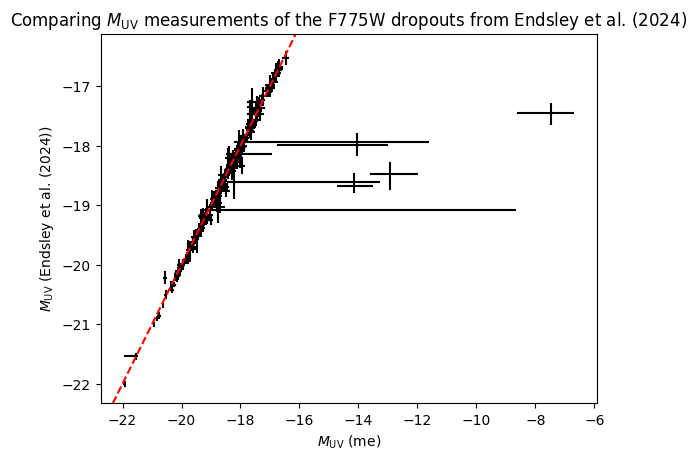

In [ ]:
compare()

Number of objects with a >= 0.2 mag difference between the two sets of M_UV measurements: 17 

Object IDs with a >= 0.2 mag difference between the two sets of M_UV measurements: ['106549_GOODSN' '110913_GOODSS' '12565_GOODSN' '14870_GOODSN'
 '16781_GOODSN' '28474_GOODSN' '31101_GOODSN' '43154_GOODSN'
 '50244_GOODSN' '56603_GOODSN' '63938_GOODSN' '66959_GOODSS'
 '86604_GOODSS' '87760_GOODSS' '90985_GOODSS' '94758_GOODSS'
 '96735_GOODSN']


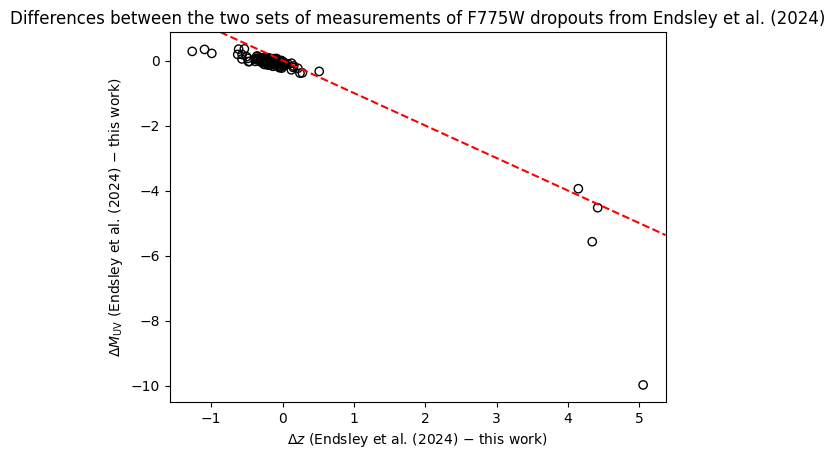

In [73]:
compare_diff()

In [62]:
bins()

The number of objects in Endsley et al. (2024)'s bright (M_UV <= -19.5) selection:  65
The number of objects in Endsley et al. (2024)'s faint (-19.5 < M_UV <= -18) selection:  138
The number of objects in Endsley et al. (2024)'s very faint (M_UV > -18) selection:  75 

The number of objects in my bright (M_UV <= -19.5) selection:  59
The number of objects in my faint (-19.5 < M_UV <= -18) selection:  136
The number of objects in my very faint (M_UV > -18) selection:  83 

The number of objects in both bright (M_UV <= -19.5) selections:  59
The number of objects in both faint (-19.5 < M_UV <= -18) selections:  128
The number of objects in both very faint (M_UV > -18) selections:  73 

Objects that shifted from the bright to faint bin and the difference in M_UV (Endsley et al. (2024) - me):  ['138229_GOODSS' '147605_GOODSS' '36173_GOODSN' '57411_GOODSS'
 '58267_GOODSN' '89814_GOODSS'] [-0.09023408 -0.04852628 -0.07526228 -0.06323969 -0.05423981 -0.07254344]
Objects that shifted from the 